In [60]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
from langdetect import detect
import umap
import umap.plot
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
%matplotlib inline

# import spacy
# import wordcloud
# import en_core_web_sm
# nlp = spacy.load('en_core_web_sm')
# from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
stops = stopwords.words('english')
stops_dict = {}
for word in stops:
    stops_dict[word]=""

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import os
abspath = os.path.abspath('D:/Box Sync/editorials/scripts/')
os.chdir(abspath)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 150)

import import_func as imp
import tags_work as tgs
import desc_vis as vis
import classifier_func as cls
import classifier_help as clh
import text_cleaning as txc
import frequency as frq

print("done")

done


In [8]:
# full_advice = "../data/genre_advice_full_021520.jl"
full_filename = "../data/by_article_fulltext_020920.jl"
frequency_filename = "../data/frequency_wordlex.csv"


full_df = imp.init_df(full_filename, "full")
full_df = full_df[full_df["year"]<2020]

full_df = full_df.drop(
    [
        "date",
        "time",
        "date_seq",
        "column1",
        "column2",
        "one_time",
        "working_life",
        "career_related_policy",
        "career_profiles",
        "bio",
        #########
        "id",
        "headline",
        "tags",
        "authors",
        "month_seq",
        "author",
        "n_posts_author",
        "advice"
    ],
    axis=1,
)

full_df.head()

,text,year,category
0,"bywelcome to ""tooling up,"" a monthly column about job hunting and career development for scienti...",1996,advice
1,"by've always hated the term ""cover letter."" it implies that the letter you send out to accompany...",1996,advice
2,"bye all know that, with respect to fashion, the world holds a rather dim view of scientists like...",1997,advice
3,"byow that the holiday season is over, you have returned to your regular life, in the lab, in sch...",1998,advice
4,by--miguel de cervantesany young scientists who explore nontraditional careers are seeking more ...,1998,advice


In [9]:
def only_letters_clean(text):
    valids = re.sub(r"[^A-Za-z ,]+", '', text)
    return(valids)

In [63]:
# frequency dictionary

text_list = full_df["text"]

word_dict = {}
text_clean = []

for text in text_list:
    text = clh.only_letters_clean(text)
    # print(text)
    word_dict = frq.add_to_freq_dict(text, word_dict) #, lemm=lemm 

In [107]:
stops = [
    "es",
    "das",
    "und",
    "den",
    "en",
    "der",
    "da",
    "die",
    "fr",
    "les",
    "un",
    "las",
    "el",
    "ai",
    "des",
    "von",
    "de",
    "ai",
    "le",
    "et",
    "dan",
    "pour",
    "gre",
    "la",
    "van",
    "est",
    "um",
    "los",
    "se",
    "hb",
    "y",
    "pr"
    ]

In [108]:
attributes = {}
sentences = []
tokens = []


for i in range(len(full_df)):
    text = full_df.iloc[i]["text"]
    category = full_df.iloc[i]["category"]
    year = full_df.iloc[i]["year"]
    if detect(text) != "en":
        continue
    text = clh.only_letters_clean(text)
    # clean_text.append(text)
    text = text.split(".")

    for sentence in text:
        token_chunk = []
        for token in sentence.split(" "):
            if token != '' and word_dict[token]>100 and token not in stops:
                token_chunk.append(token)
                if token not in attributes:
                    attributes[token] = {"advice":0,"years":[]}
                attributes[token]["years"].append(year)
                if category == "advice":
                    attributes[token]["advice"]+=1
        tokens.append(token_chunk)
        # tokens.append([token for token in sentence.split(' ') if token != "" if word_dict[token]>50])




In [109]:
print(len(tokens))
print(sum([len(item) for item in tokens]))

5948
5852484


In [110]:
dimensions=100
window=5
minfrequency=10
numworkers=3
iterations=3

model = gensim.models.Word2Vec(
            tokens,
            size = dimensions,
            window = window, # just use the entire sentence
            min_count = minfrequency, # Remove tokens that don't appear enough
            workers = numworkers, # paralellize, use 4 workers
            iter = 5,
            sg = 1 # use the skip_gram model
) # end model

umap reduction

In [111]:
# The number of components to reduce to
N_COMPONENTS = 2
AXIS1_COLUMN_NAME = 'axis1'
AXIS2_COLUMN_NAME = 'axis2'
TOKEN_COLUMN_NAME = 'token'

metric="cosine"
neighbors=5
mindistance=0.1
output="../data/reduced_umap.csv"

In [112]:
vectors = [model[word] for word in model.wv.vocab]
tokens = [word for word in model.wv.vocab]

In [113]:
# Setup the UMAP reducer
reducer = umap.UMAP(metric = metric,
                    n_neighbors = neighbors,
                    min_dist = mindistance,
                    n_components = N_COMPONENTS
                    )
umap_embedding = reducer.fit_transform(vectors)

In [114]:
# Convert to pandas dataframe and assign axis names
umap_coords_df = pd.DataFrame(umap_embedding, columns = [AXIS1_COLUMN_NAME, AXIS2_COLUMN_NAME])

# Add the token (word) as a column, labelling each coordinate
umap_coords_df[TOKEN_COLUMN_NAME] = tokens

In [59]:
# Save the output plain
umap_coords_df.to_csv(output)

umap_coords_df.head()

,axis1,axis2,token
0,10.769539,3.037711,to
1,7.235555,1.854195,tooling
2,12.971490,5.344561,up
3,3.871880,3.104661,a
4,7.675076,5.473386,monthly


In [115]:
# incidence of word in advice to dataframe
advice_prop = []
med_year = []

for token in umap_coords_df["token"]:
    advice_prop.append(attributes[token]["advice"]/word_dict[token])
    med_year.append(np.median(attributes[token]["years"]))

umap_coords_df["advice_prop"] = advice_prop
umap_coords_df["med_year"] = med_year

umap_coords_df.to_csv(output)

In [106]:
umap_coords_df.head(30)

,axis1,axis2,token,advice_prop,med_year
0,-1.734044,7.810099,to,0.422405,2005.0
1,5.128009,5.086278,tooling,0.884058,2006.0
2,2.442078,4.503065,up,0.427757,2005.0
3,9.192839,10.054314,a,0.418715,2006.0
4,0.099239,12.727993,monthly,0.550000,2004.0
5,5.099446,5.045375,column,0.590566,2005.0
6,1.529315,7.147226,about,0.441557,2006.0
7,6.225635,8.241591,job,0.489572,2005.0
8,2.296885,6.144041,hunting,0.504425,2003.0
9,-0.867589,10.541399,and,0.400126,2005.0


plots

In [51]:
reducer = umap.UMAP(metric = metric,
                    n_neighbors = neighbors,
                    min_dist = mindistance,
                    n_components = N_COMPONENTS
                    )
umap_embedding = reducer.fit(vectors)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


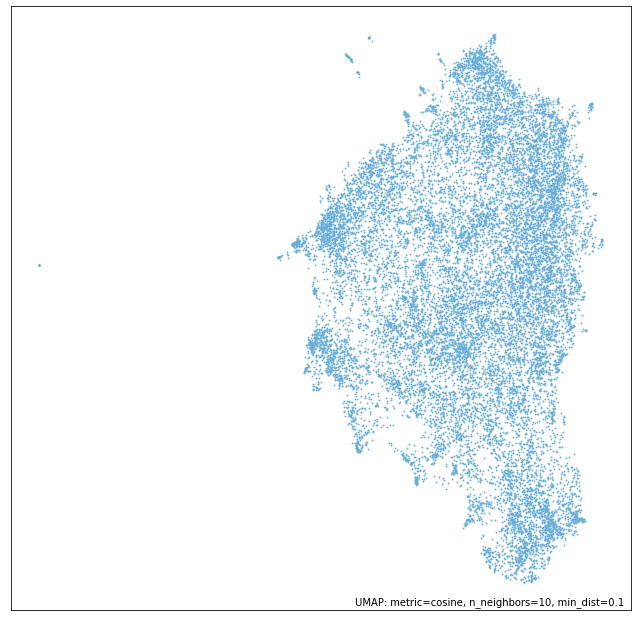

In [52]:
umap.plot.points(umap_embedding)